The plots saved by this notebook are called "LDB", which stands for "large database".

In [10]:
import tangos as db
import numpy as np
import matplotlib.pyplot as plt
import random

In [11]:
db.all_simulations()

[<Simulation("Tempest.9f11c.all.DD")>]

In [12]:
sim = db.get_simulation('Tempest.9f11c.all.DD')

In [15]:
sats = sim[-1][1].calculate('Satellites()')
print(sats)

[<Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_87' | NDM=110 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_54' | NDM=171 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_21' | NDM=517 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_109' | NDM=84 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_50' | NDM=183 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_12' | NDM=1357 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_115' | NDM=78 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_118' | NDM=75 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_99' | NDM=96 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_73' | NDM=139 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_100' | NDM=96 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_51' | NDM=182 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_113' | NDM=82 Ns

In [77]:
i = 0

all_sat_t = []
all_sat_r = []
all_sat_ratio = []
all_sat_mvir = []
all_sat_mvir_ratio = []
all_sat_mvir_max = []
all_host_rvir = []

while i < np.size(sats):
    
    # this finds the index of each of the satellite halos
    sat_idx = sats[i].halo_number
    
    # this finds the index of the host for each of the satellite halos. the index should be
    # the same for all haloes, but this is coded separately to account for the case where
    # the host halo changes index as its mass profile evolves.
    
    host = sats[i].calculate('Hosts()')
    host_idx = host[0].halo_number
            
    # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
    host_rvir, host_mvir, host_x, host_y, host_z, host_t = \
                        sim[-1][host_idx].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')
    sat_mvir, sat_x, sat_y, sat_z, sat_t = \
                        sim[-1][sat_idx].calculate_for_progenitors('Mvir', 'X', 'Y', 'Z', 't()')

    # now, we have to correct for the distance of the satellite halos from the host halo, which itself
    # is also moving. to do this, we need to subtract the position of the satellite by the position of
    # the host. 
    # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
    # we first need to exclude the non-overlapping redshifts so that it's easier to subtract

    ### this checks for non-overlapping redshifts between host and satellite. 
    ### if non-overlapping, then array element set to 0
    for j in range(np.size(host_t)):
        if host_t[j] not in sat_t: 
            host_t[j] = 0.
            host_x[j] = 0.
            host_y[j] = 0.
            host_z[j] = 0.
            host_rvir[j] = 0.
            host_mvir[j] = 0.

    ### this checks for non-overlapping redshifts between satellite and host. 
    ### if non-overlapping, then array element set to 0
    for k in range(np.size(sat_t)):
        if sat_t[k] not in host_t:
            sat_t[k] = 0.
            sat_x[k] = 0.
            sat_y[k] = 0.
            sat_z[k] = 0.
            sat_mvir[k] = 0.

    ### this removes all the zeros
    host_t = host_t[host_t != 0.]
    host_x = host_x[host_x != 0.]
    host_y = host_y[host_y != 0.]
    host_z = host_z[host_z != 0.]
    host_rvir = host_rvir[host_rvir != 0.]
    host_mvir = host_mvir[host_mvir != 0.]
    sat_t = sat_t[sat_t != 0.]
    sat_x = sat_x[sat_x != 0.]
    sat_y = sat_y[sat_y != 0.]
    sat_z = sat_z[sat_z != 0.]
    sat_mvir = sat_mvir[sat_mvir != 0.]

    # here comes the actual subtracting correction
    sat_x = sat_x - host_x
    sat_y = sat_y - host_y
    sat_z = sat_z - host_z

    # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
    sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)

    # this plots distance vs. time for each halo with regard to their host halo
    mass_ratio = sat_mvir / max(sat_mvir)
        
    all_sat_t.append(sat_t)
    all_sat_r.append(sat_r * 1000)
    all_sat_ratio.append(sat_r * 1000 / host_rvir)
    all_sat_mvir.append(sat_mvir)
    all_sat_mvir_ratio.append(mass_ratio)
    all_sat_mvir_max.append(max(sat_mvir))
    all_host_rvir.append(host_rvir)
        
    print(sat_idx)
            
    i += 1
    
all_sat_t = np.array(all_sat_t, dtype='object')
all_sat_r = np.array(all_sat_r, dtype='object')
all_sat_ratio = np.array(all_sat_ratio, dtype='object')
all_sat_mvir_max = np.array(all_sat_mvir_max, dtype='object')
all_sat_mvir = np.array(all_sat_mvir, dtype='object')

print('success!')

87
54
21
109
50
12
115
118
99
73
100
51
113
127
27
success!


In [78]:
# this is just to generate the same colors for both plots

r_array = []
b_array = []
g_array = []

for i in range(np.size(all_sat_t)):
    r = random.random()
    b = random.random()
    g = random.random()
    r_array.append(r)
    b_array.append(b)
    g_array.append(g)
    
r_array = np.array(r_array)
b_array = np.array(b_array)
g_array = np.array(g_array)

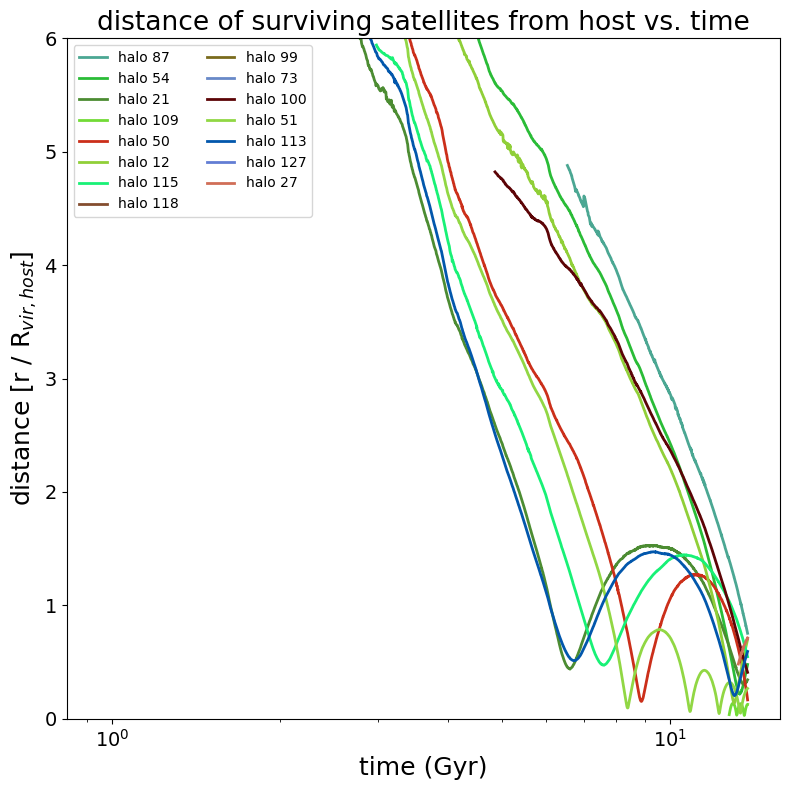

In [79]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    plt.plot(all_sat_t[i], all_sat_ratio[i], linewidth=2, c=(r_array[i], b_array[i], g_array[i]), \
            label='halo ' + str(sats[i].halo_number))

plt.legend(loc='upper left', prop={'size': 10}, ncol=2)
plt.title('distance of surviving satellites from host vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim(0, 6)
#plt.xlim(2, max(sat_t))
plt.xscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/LDB_satellite_over_time.png')

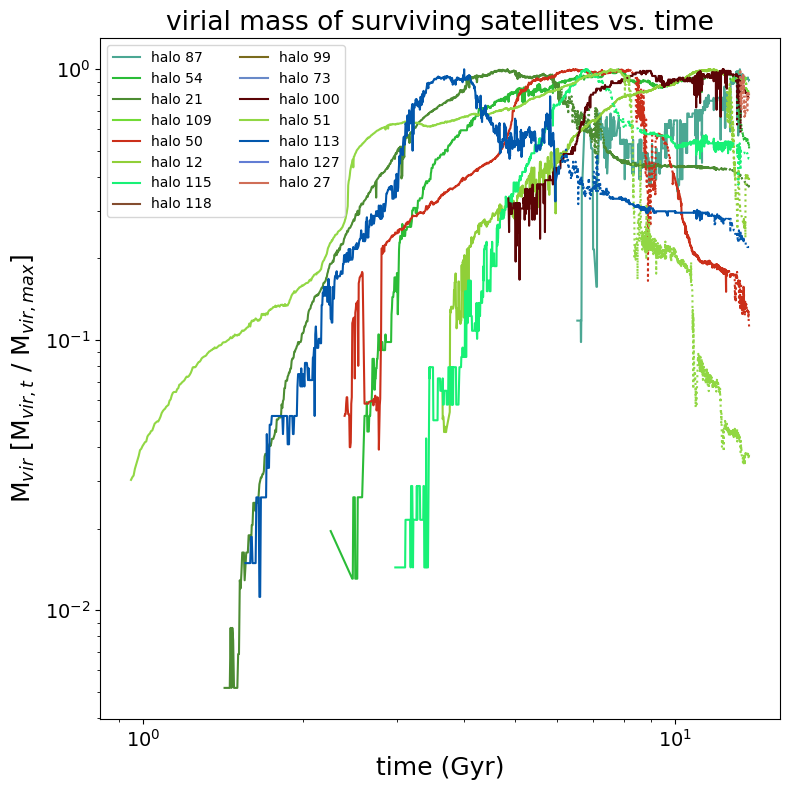

In [80]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    radius_ratio = all_sat_r[i] / all_host_rvir[i]
    in_rvir = radius_ratio <= 1
    out_rvir = radius_ratio > 1
    plt.plot(all_sat_t[i], np.ma.masked_where(in_rvir, all_sat_mvir_ratio[i]), linestyle='-', \
             c=(r_array[i], b_array[i], g_array[i]), label='halo ' + str(sats[i].halo_number))
    plt.plot(all_sat_t[i], np.ma.masked_where(out_rvir, all_sat_mvir_ratio[i]), linestyle=':', \
             c=(r_array[i], b_array[i], g_array[i]))
    
plt.legend(loc='upper left', prop={'size': 10}, ncol=2)
plt.title('virial mass of surviving satellites vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir}$ [M$_{vir,t}$ / M$_{vir,max}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/LDB_satellite_mvir_over_time.png')

In [81]:
"""
Next, we investigate if any of the satellites have their peak Mvir
at the first time of appearance in the simulation.
"""

first_time_peak_idx = []
how_many_peaks = 0
for i in range(np.size(all_sat_mvir)):
    if all_sat_mvir[i][0] == max(all_sat_mvir[i]):
        how_many_peaks += 1
        print('halo ' + str(sats[i].halo_number) + \
              ' peaks in Mvir at the first time of appearance; array index: ' + str(i))
        first_time_peak_idx.append(i)

print('\nIn total, ' + str(how_many_peaks) + '/' + str(np.size(all_sat_mvir)) + \
      ' halos peak in Mvir at the first time of appearance.')

halo 118 peaks in Mvir at the first time of appearance; array index: 7
halo 99 peaks in Mvir at the first time of appearance; array index: 8
halo 73 peaks in Mvir at the first time of appearance; array index: 9
halo 127 peaks in Mvir at the first time of appearance; array index: 13

In total, 4/15 halos peak in Mvir at the first time of appearance.


In [82]:
"""
Here, we'll try to find out the time of first in-fall
and the peak Mvir of each of the satellite halos
"""

first_infall = np.zeros(np.size(all_sat_t))

for i in range(np.size(all_sat_t)):
    each_halo = all_sat_t[i]
    radius_ratio = all_sat_r[i] / all_host_rvir[i]
    infalls = each_halo[radius_ratio <= 1]
    if np.size(infalls) == 0:
        first_infall[i] = 0
    else:
        first_infall[i] = min(infalls)
        
with open("Mvir_vs_1st_infall_surviving.txt", "w") as f:
    for idx in range(np.size(all_sat_t)):
        if idx in first_time_peak_idx:
            f.write(str(first_infall[idx]) + ' ' + str(all_sat_mvir_max[idx]) + ' ' + str(1))
            f.write('\n')
        else:
            f.write(str(first_infall[idx]) + ' ' + str(all_sat_mvir_max[idx]) + ' ' + str(0))
            f.write('\n')
        
f.close()
        
print(first_infall, np.size(first_infall))
print(all_sat_mvir_max, np.size(all_sat_mvir_max))

[13.41227214 12.28259844  6.10166949 12.75598551  8.18349673 12.01900791
  6.88706168 13.75931383 13.75931383 13.75931383 12.76674431  7.72624785
  6.10166949 13.75931383 13.24551078] 15
[70805755.39568345 212417266.18705037 1614676258.992806 136058992.8057554
 1699280575.5395684 1310604316.5467627 192978417.26618707
 9718417.266187051 2776690.6474820147 5553381.294964029 99961151.0791367
 6044892086.3309355 372071942.4460432 15271942.446043167
 37484892.086330935] 15
